In [5]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
df=pd.read_csv('/content/DailyDelhiClimateTest.csv')

In [4]:
df=df[['date','meantemp']]

In [7]:
X=df['date']

In [8]:
y=df['meantemp']

In [21]:
df.head()


,date,meantemp
0,2017-01-01,15.913043
1,2017-01-02,18.500000
2,2017-01-03,17.111111
3,2017-01-04,18.700000
4,2017-01-05,18.388889


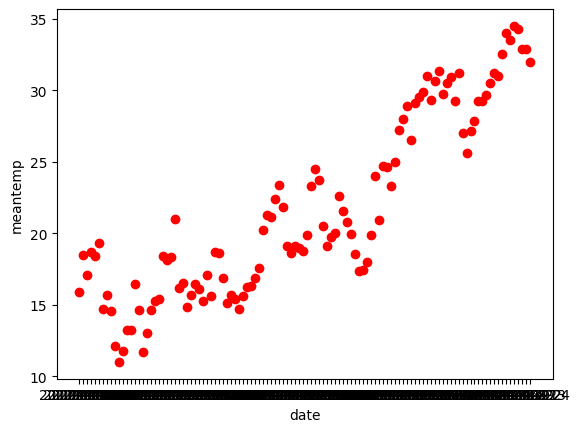

In [16]:
import matplotlib.pyplot as plt

plt.scatter(df['date'], df['meantemp'], color='red')
plt.xlabel("date")
plt.ylabel("meantemp")
plt.show()


In [19]:
x1=df.iloc[:,1:2].ewm(alpha=0.9).mean()

In [22]:
df['ewm']=x1

In [23]:
df.head()

,date,meantemp,ewm
0,2017-01-01,15.913043,15.913043
1,2017-01-02,18.500000,18.264822
2,2017-01-03,17.111111,17.225443
3,2017-01-04,18.700000,18.552677
4,2017-01-05,18.388889,18.405266


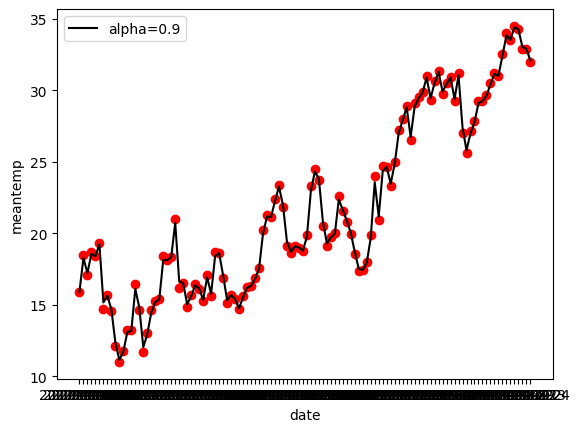

In [24]:

plt.scatter(df['date'], df['meantemp'], color='red')
plt.plot(df['date'],x1,color='black',label='alpha=0.9')
plt.xlabel("date")
plt.ylabel("meantemp")
plt.legend()
plt.show()


Initial df.shape: (114, 2)
date        0
meantemp    0
dtype: int64
After coercion and checking NaNs: date        0
meantemp    0
dtype: int64
After dropping bad targets: (114, 2)
Train shape: (91, 2) (91, 1) Val shape: (23, 2) (23, 1)
Epoch 1 | Train MSE: 520.202101 | Val MSE: 447.271515
Epoch 40 | Train MSE: 51.024958 | Val MSE: 37.766257
Epoch 80 | Train MSE: 10.203769 | Val MSE: 9.424555
Epoch 120 | Train MSE: 7.507695 | Val MSE: 9.521725
Epoch 160 | Train MSE: 7.328675 | Val MSE: 10.041207
Epoch 200 | Train MSE: 7.317301 | Val MSE: 10.206882
Training finished. Learned params (on standardized feature space): [21.89158159  5.74221482]


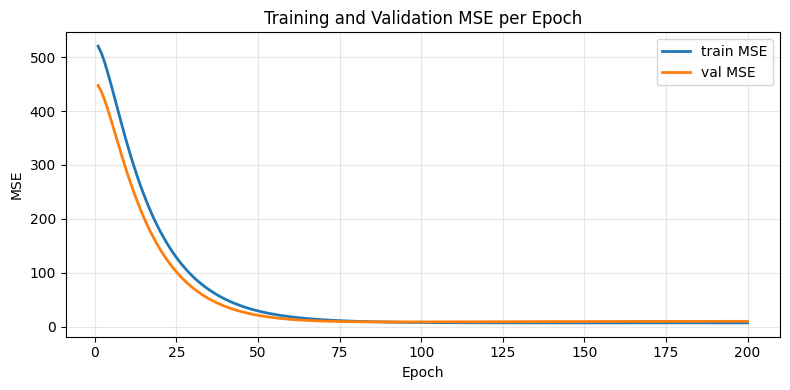

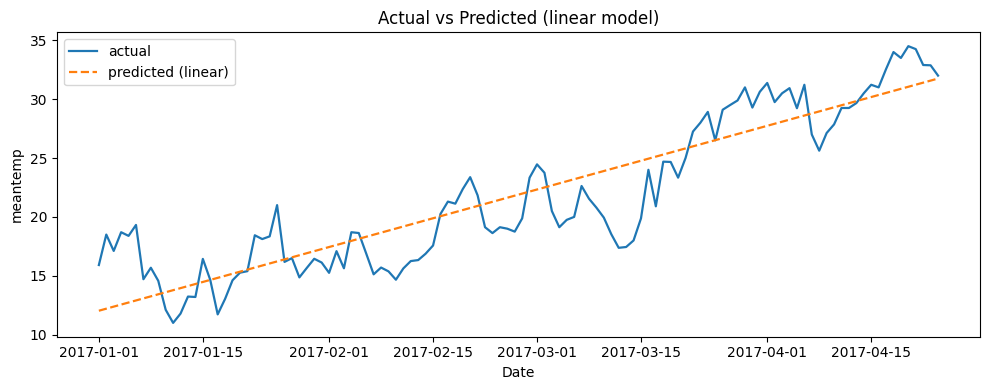

In [18]:
# Full: cleaner + retrain + proper plotting (loss curves + actual vs predicted)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- assume df exists with columns 'date' and 'meantemp' ---
if 'df' not in globals():
    raise RuntimeError("Please load your dataframe into variable `df` with columns 'date' and 'meantemp'")

# 1) Basic diagnostics + cleaning
print("Initial df.shape:", df.shape)
print(df.isna().sum())

df_clean = df[['date', 'meantemp']].copy()
df_clean['meantemp'] = pd.to_numeric(df_clean['meantemp'], errors='coerce')
print("After coercion and checking NaNs:", df_clean.isna().sum())

# Drop non-finite target rows
df_clean = df_clean[np.isfinite(df_clean['meantemp'].values)].reset_index(drop=True)
print("After dropping bad targets:", df_clean.shape)

# Create numeric feature(s)
N = df_clean.shape[0]
day_idx = np.arange(N).reshape(-1, 1).astype(float)

# Feature matrix: bias + day index
X = np.hstack([np.ones((N, 1)), day_idx])   # shape (N, D)
y = df_clean['meantemp'].values.reshape(-1, 1)

# Check for non-finite in X or y
rows_with_nonfinite = np.where(~(np.isfinite(X).all(axis=1) & np.isfinite(y).ravel()))[0]
if len(rows_with_nonfinite) > 0:
    print("Rows with non-finite values in X or y:", rows_with_nonfinite)
    mask = np.isfinite(X).all(axis=1) & np.isfinite(y).ravel()
    X = X[mask]
    y = y[mask].reshape(-1,1)
    N = X.shape[0]
    print("Dropped non-finite rows. New N =", N)

if N == 0:
    raise RuntimeError("No valid rows left after cleaning. Cannot train.")

# 2) Standardize non-bias feature for stability
X_no_bias = X[:, 1:2]
mean_feat = X_no_bias.mean(axis=0)
std_feat = X_no_bias.std(axis=0)
std_feat[std_feat == 0] = 1.0
X[:, 1:2] = (X_no_bias - mean_feat) / std_feat

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, y_train.shape, "Val shape:", X_val.shape, y_val.shape)

# 3) Hyperparams and init
lr = 5e-4
momentum = 0.9
n_epochs = 200
batch_size = 32

rng = np.random.default_rng(0)
w = rng.normal(scale=0.1, size=(X.shape[1], 1))
v = np.zeros_like(w)

assert np.isfinite(w).all() and np.isfinite(v).all(), "Initial params non-finite"

def compute_grad(Xb, yb, w):
    Nb = Xb.shape[0]
    if Nb == 0:
        return np.zeros_like(w)
    preds = Xb.dot(w)
    error = preds - yb
    grad = (2.0 / Nb) * Xb.T.dot(error)
    return grad

# Lists to record losses per epoch
train_losses = []
val_losses = []

# 4) Training loop with debugging
for epoch in range(1, n_epochs + 1):
    perm = rng.permutation(X_train.shape[0])
    X_shuf = X_train[perm]
    y_shuf = y_train[perm]
    for i in range(0, X_train.shape[0], batch_size):
        Xb = X_shuf[i:i+batch_size]
        yb = y_shuf[i:i+batch_size]
        if Xb.shape[0] == 0:
            continue

        batch_global_idx = perm[i:i+Xb.shape[0]]
        grad = compute_grad(Xb, yb, w)
        if not np.isfinite(grad).all():
            print("Non-finite gradient detected at epoch", epoch, "batch begin index", i)
            print("Batch size:", Xb.shape[0])
            print("Global indices of batch rows:", batch_global_idx.tolist())
            print("Batch Xb (first 10 rows):\n", Xb[:10])
            print("Batch yb (first 10 rows):\n", yb[:10])
            orig_day_idx = (X[batch_global_idx, 1:2] * std_feat + mean_feat).ravel()
            print("Original day_idx for these rows:", orig_day_idx.tolist())
            raise RuntimeError("Gradient contains NaN or inf. See printed info above.")

        v = momentum * v + grad
        if not np.isfinite(v).all():
            print("Non-finite velocity at epoch", epoch)
            raise RuntimeError("v contains NaN or inf.")
        w = w - lr * v

    # compute epoch losses and record
    train_pred = X_train.dot(w)
    val_pred = X_val.dot(w)
    if not (np.isfinite(train_pred).all() and np.isfinite(val_pred).all()):
        print("Non-finite predictions detected. Aborting.")
        raise RuntimeError("Predictions non-finite.")

    train_loss = mean_squared_error(y_train, train_pred)
    val_loss = mean_squared_error(y_val, val_pred)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 40 == 0 or epoch == 1:
        print(f"Epoch {epoch} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

print("Training finished. Learned params (on standardized feature space):", w.ravel())

# 5) Plot full loss curves (per epoch)
if len(train_losses) > 0:
    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_losses, label="train MSE", linewidth=2)
    plt.plot(epochs, val_losses, label="val MSE", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training and Validation MSE per Epoch")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No loss history to plot.")

# 6) Predicted vs Actual time-series plot (un-standardize x for interpretability)
pred_all = X.dot(w)  # predictions in original target scale already

# Ensure df_clean['date'] is datetime for correct plotting
if not np.issubdtype(df_clean['date'].dtype, np.datetime64):
    df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce')

# Use only the rows corresponding to current X (we may have dropped some earlier)
N_used = pred_all.shape[0]
dates_used = df_clean['date'].iloc[:N_used]

plt.figure(figsize=(10,4))
plt.plot(dates_used, y.ravel(), label="actual", linewidth=1.6)
plt.plot(dates_used, pred_all.ravel(), label="predicted (linear)", linestyle='--', linewidth=1.6)
plt.xlabel("Date")
plt.ylabel("meantemp")
plt.title("Actual vs Predicted (linear model)")
plt.legend()
plt.tight_layout()
plt.show()
